# Fine-tuning EfficientNet B0 for Skin Fitzpatrick Type Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 582.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.9 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.19.0
3.8.0


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0

# Create 70:15:15 Split Dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = '/content/drive/MyDrive/skin_type_classification/dataset'
base_dir = '/content/drive/MyDrive/skin_type_classification/split_dataset'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create directories if they don't exist
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Loop over all class folders
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_dir)

    # Split the data into train, val, test
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)  # 30% for val+test
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)  # 50% of 30% for each = 15%

    # Create class directories in train, val, and test if they don't exist
    for split_dir in [train_dir, val_dir, test_dir]:
        class_split_dir = os.path.join(split_dir, class_name)
        if not os.path.exists(class_split_dir):
            os.makedirs(class_split_dir)

    # Copy files to the respective directories
    for image_name in train_images:
        shutil.copy(os.path.join(class_dir, image_name), os.path.join(train_dir, class_name))

    for image_name in val_images:
        shutil.copy(os.path.join(class_dir, image_name), os.path.join(val_dir, class_name))

    for image_name in test_images:
        shutil.copy(os.path.join(class_dir, image_name), os.path.join(test_dir, class_name))

print("Dataset splitting completed.")

Dataset splitting completed.


# Prepare Data for model training and evaluation

In [ ]:
# Paths
base_dir = '/content/drive/MyDrive/skin_type_classification/split_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = 224
BATCH_SIZE = 128

In [ ]:
# Data augmentation layers
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# Preprocessing functions
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

def input_preprocess_test(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

# Load and preprocess data
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_dataset.class_names
num_classes = len(class_names)

# Dataset mapping
train_dataset = train_dataset.map(input_preprocess_train)
val_dataset = val_dataset.map(input_preprocess_test)
test_dataset = test_dataset.map(input_preprocess_test)

Found 2008 files belonging to 5 classes.
Found 427 files belonging to 5 classes.
Found 432 files belonging to 5 classes.


# Define model architecture with custom layers

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    base_model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, name="top_dropout")(x)  # Increased from 0.2 to 0.5

    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        name="pred",
        kernel_regularizer=regularizers.l2(0.001)  # L2 regularization added
    )(x)

    model = models.Model(inputs, outputs, name="EfficientNet")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #reduced 2 to 3
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_model(num_classes)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train and save the trained model (transfer learning)

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 276s 17s/step - accuracy: 0.2227 - loss: 2.5887 - val_accuracy: 0.2787 - val_loss: 1.5854
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 258s 16s/step - accuracy: 0.2724 - loss: 2.1772 - val_accuracy: 0.3091 - val_loss: 1.5279
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 258s 16s/step - accuracy: 0.3056 - loss: 2.0081 - val_accuracy: 0.3372 - val_loss: 1.4843
Epoch 4/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 257s 16s/step - accuracy: 0.3325 - loss: 1.9724 - val_accuracy: 0.3700 - val_loss: 1.4560
Epoch 5/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 257s 16s/step - accuracy: 0.3502 - loss: 1.7884 - val_accuracy: 0.3794 - val_loss: 1.4320
Epoch 6/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 257s 16s/step - accuracy: 0.3498 - loss: 1.8016 - val_accuracy: 0.3724 - val_loss: 1.4081
Epoch 7/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 258s 16s/step - accuracy: 0.3969 - loss: 1.6858 - val_accuracy: 0.3794 - val_loss: 1.3920
Epoch 8/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 257s 16s/step - accuracy: 0.3734 - loss: 1.6395 - val_accuracy: 0.

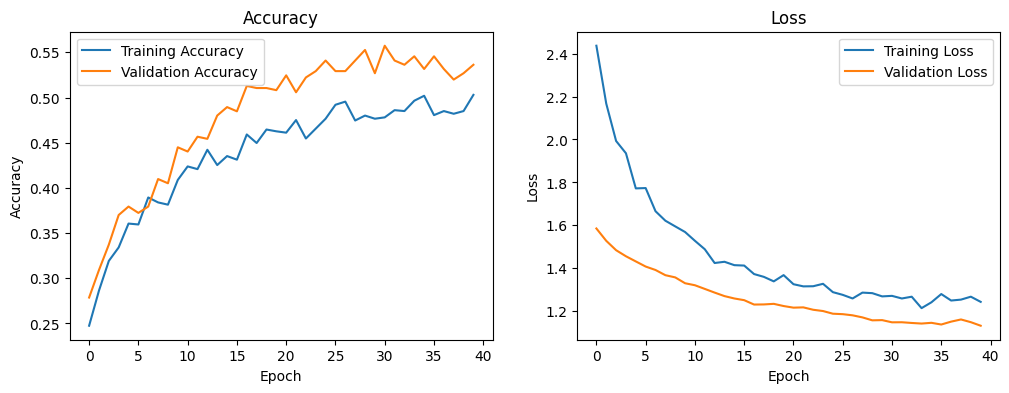

4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.5533 - loss: 1.1512
Test Accuracy: 0.5440
Test Loss: 1.1644


In [ ]:
epochs = 40

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

plot_history(history)

model_dir = '/content/drive/MyDrive/skin_type_classification'
model_path = os.path.join(model_dir, 'saved_model_r224.keras')
model.save(model_path)
model.save_weights('model_weights_r224.weights.h5')


test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Fine-tune the trained model by unfreezing model weights for few layers

In [ ]:
#continue from prev. checkpoint weights

from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/skin_type_classification/saved_model_r224.keras'
model = load_model(model_path)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 341s 20s/step - accuracy: 0.4609 - loss: 1.2875 - val_accuracy: 0.5246 - val_loss: 1.1451
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 245s 15s/step - accuracy: 0.5384 - loss: 1.1491 - val_accuracy: 0.5363 - val_loss: 1.1025
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 267s 16s/step - accuracy: 0.5566 - loss: 1.0959 - val_accuracy: 0.5995 - val_loss: 1.0223
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 259s 15s/step - accuracy: 0.5940 - loss: 1.0128 - val_accuracy: 0.6464 - val_loss: 0.9087
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 265s 16s/step - accuracy: 0.6316 - loss: 0.9369 - val_accuracy: 0.6276 - val_loss: 0.9559
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 244s 15s/step - accuracy: 0.6456 - loss: 0.9234 - val_accuracy: 0.6745 - val_loss: 0.8366
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 258s 15s/step - accuracy: 0.6719 - loss: 0.8509 - val_accuracy: 0.6838 - val_loss: 0.8447
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 269s 15s/step - accuracy: 0.6997 - loss: 0.7845 - val_accuracy: 0.

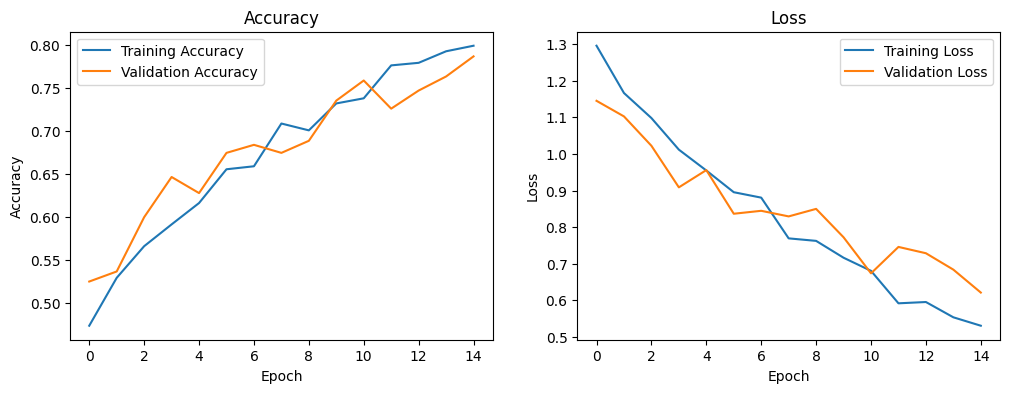

4/4 ━━━━━━━━━━━━━━━━━━━━ 63s 12s/step - accuracy: 0.7625 - loss: 0.6760
Test Accuracy: 0.7546
Test Loss: 0.6753


In [ ]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

epochs = 15
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

plot_history(history)

model_dir = '/content/drive/MyDrive/skin_type_classification'
model_path = os.path.join(model_dir, 'saved_model_ft_r224_e15.keras')
model.save(model_path)
model.save_weights('model_weights_ft_r224_e15.weights.h5')

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
#continue from prev. checkpoint weights

from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/skin_type_classification/saved_model_ft_r224_e15.keras'
model = load_model(model_path)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 324s 19s/step - accuracy: 0.8054 - loss: 0.5281 - val_accuracy: 0.7564 - val_loss: 0.7116
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 268s 16s/step - accuracy: 0.8293 - loss: 0.5069 - val_accuracy: 0.7916 - val_loss: 0.6132
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 256s 16s/step - accuracy: 0.8431 - loss: 0.4589 - val_accuracy: 0.8244 - val_loss: 0.5485
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 263s 15s/step - accuracy: 0.8290 - loss: 0.4696 - val_accuracy: 0.7986 - val_loss: 0.5939
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 269s 16s/step - accuracy: 0.8534 - loss: 0.4357 - val_accuracy: 0.7845 - val_loss: 0.6329
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 246s 15s/step - accuracy: 0.8670 - loss: 0.3780 - val_accuracy: 0.7822 - val_loss: 0.6330
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 270s 16s/step - accuracy: 0.8707 - loss: 0.3798 - val_accuracy: 0.8080 - val_loss: 0.5551
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 260s 16s/step - accuracy: 0.8696 - loss: 0.3644 - val_accuracy: 0.

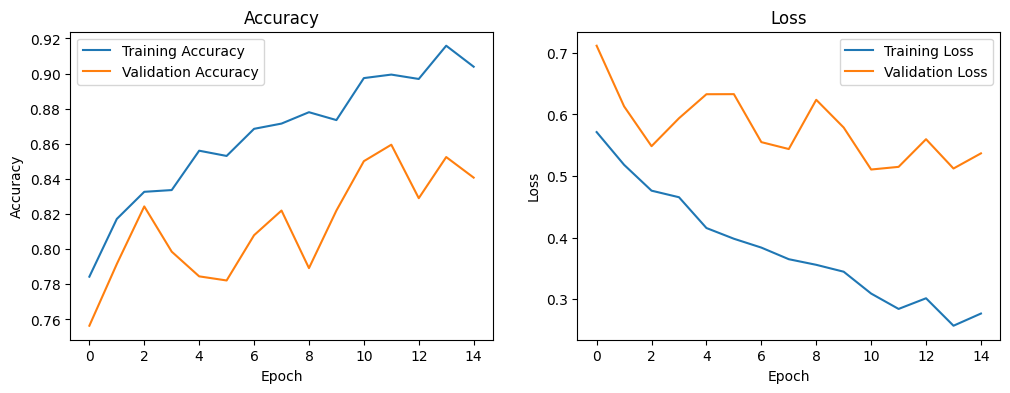

4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 10s/step - accuracy: 0.8413 - loss: 0.6025
Test Accuracy: 0.8403
Test Loss: 0.5768


In [ ]:
# another 15 epochs

def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model)

epochs = 15
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

plot_history(history)

model_dir = '/content/drive/MyDrive/skin_type_classification'
model_path = os.path.join(model_dir, 'saved_model_ft_r224_e30.keras')
model.save(model_path)
model.save_weights('model_weights_ft_r224_e30.weights.h5')

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
import tensorflow as tf

# Load your model
model = tf.keras.models.load_model("/content/drive/MyDrive/skin_type_classification/saved_model_ft_r224_e30.keras")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_model = converter.convert()

# Save to Drive
output_path = "/content/drive/MyDrive/skin_type_classification/skin_type_model_compatible.tflite"
with open(output_path, "wb") as f:
    f.write(tflite_model)

print(f"Model saved at {output_path}")


Saved artifact at '/tmp/tmpsrhk84zw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136363607547280: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136363607546512: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136363619936080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136363619939344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136363619938384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136363619940688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136363619940496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136363619938576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136363619937040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136363619935888: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [ ]:
import tensorflow as tf

# Load the trained Keras model
model_path = '/content/drive/MyDrive/skin_type_classification/saved_model_ft_r224_e30.keras'
model = tf.keras.models.load_model(model_path)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Optional: Enable optimizations for smaller model size and faster inference
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Optional: For integer quantization, you can also add a representative dataset

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = '/content/drive/MyDrive/skin_type_classification/skin_type_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("✅ TFLite model saved to:", tflite_model_path)


Saved artifact at '/tmp/tmp5ul2wso0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  135569500678736: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135569500672208: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135572243566800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135572243566224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135572243563152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135572243562576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135572243566608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135572243563344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135569612185936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135569612183824: TensorSpec(shape=(), dtype=tf.resource, name=None)

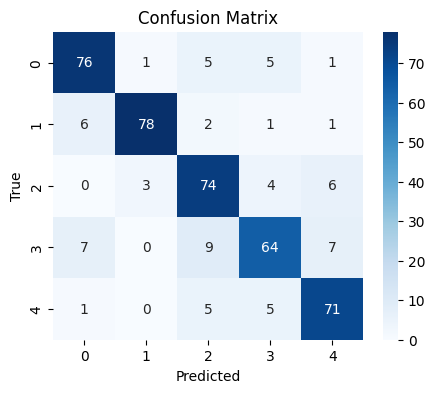

Classification Report:

              precision    recall  f1-score   support

   Type I/II       0.84      0.86      0.85        88
    Type III       0.95      0.89      0.92        88
     Type IV       0.78      0.85      0.81        87
      Type V       0.81      0.74      0.77        87
     Type VI       0.83      0.87      0.85        82

    accuracy                           0.84       432
   macro avg       0.84      0.84      0.84       432
weighted avg       0.84      0.84      0.84       432



In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/skin_type_classification/saved_model_ft_r224_e30.keras'
model = load_model(model_path)


y_true = []
y_pred = []

for images, labels in test_dataset:
    y_pred_prob = model(images, training=False)
    y_pred_batch = tf.argmax(y_pred_prob, axis=1)
    y_true_batch = tf.argmax(labels, axis=1)

    y_true.extend(y_true_batch.numpy())
    y_pred.extend(y_pred_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=['Type I/II', 'Type III', 'Type IV', 'Type V', 'Type VI'])
print("Classification Report:\n")
print(class_report)


In [ ]:
# Overall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()
accuracy_metric = tf.keras.metrics.Accuracy()

for images, labels in test_dataset:
    y_pred_prob = model(images, training=False)
    y_pred = tf.argmax(y_pred_prob, axis=1)
    y_true = tf.argmax(labels, axis=1)

    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)
    accuracy_metric.update_state(y_true, y_pred)

precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()

f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.9649
Recall: 0.9593
F1-score: 0.9621
Accuracy: 0.8403


# Model Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class index: 4
Predicted label: Type VI
Confidence score: 0.8895


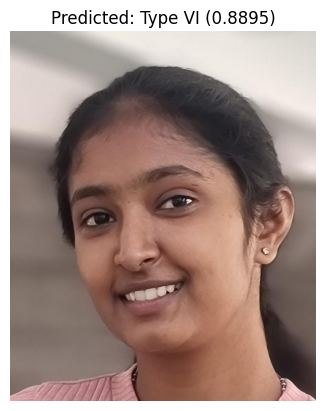

In [ ]:
# Loads saved model to perform inference

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the saved model
model_path = '/content/drive/MyDrive/skin_type_classification/saved_model_ft_r224_e30.keras'
model = load_model(model_path)

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array, Image.open(img_path)  # Return original image for display

img_path = '/content/drive/MyDrive/skin_type_classification/test_images/hkn.jpg' #3430 3503 4251 336
img_array, original_image = preprocess_image(img_path)

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)
confidence_scores = predictions[0]

class_labels = ['Type I/II', 'Type III', 'Type IV', 'Type V', 'Type VI']
predicted_label = class_labels[predicted_class[0]]
confidence_score = confidence_scores[predicted_class[0]]

print(f"Predicted class index: {predicted_class[0]}")
print(f"Predicted label: {predicted_label}")
print(f"Confidence score: {confidence_score:.4f}")

# Display the image
plt.imshow(original_image)
plt.axis('off')
plt.title(f"Predicted: {predicted_label} ({confidence_score:.4f})")
plt.show()

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Image: type5_1.png
Predicted: Type V (Confidence: 0.9993)



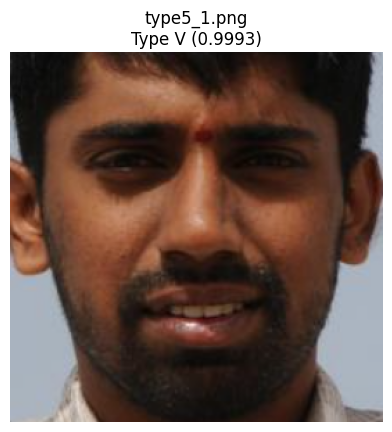

Image: type3_1.png
Predicted: Type V (Confidence: 0.9995)



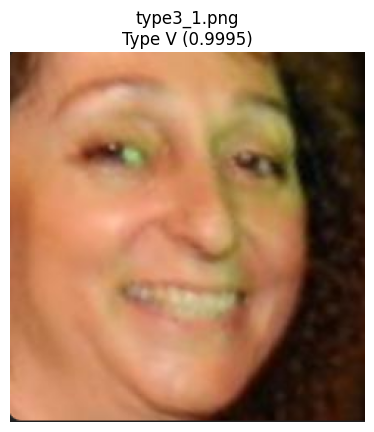

Image: type6_1.png
Predicted: Type VI (Confidence: 0.4070)



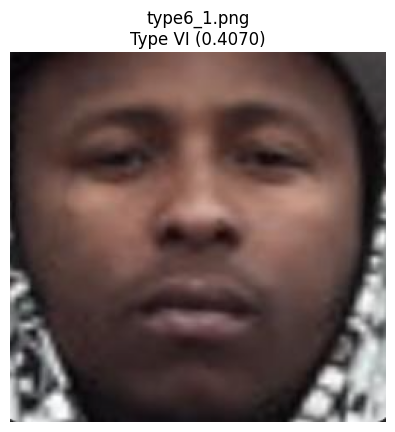

Image: type1or2_1.png
Predicted: Type I/II (Confidence: 0.9628)



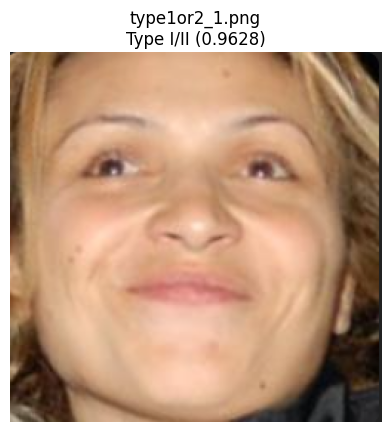

Image: type1_1.png
Predicted: Type I/II (Confidence: 0.9960)



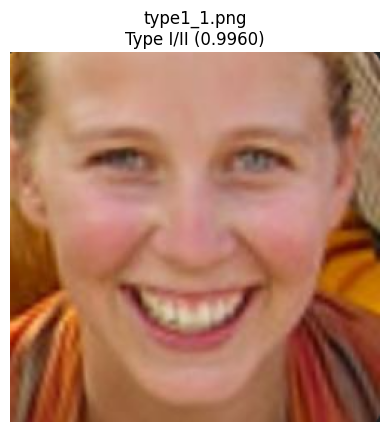

Image: type4or5_2.png
Predicted: Type V (Confidence: 0.9681)



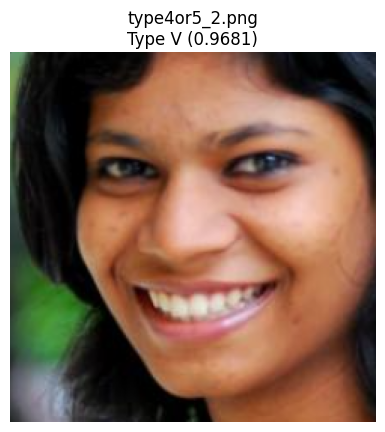

Image: type4or5_1.png
Predicted: Type V (Confidence: 0.9938)



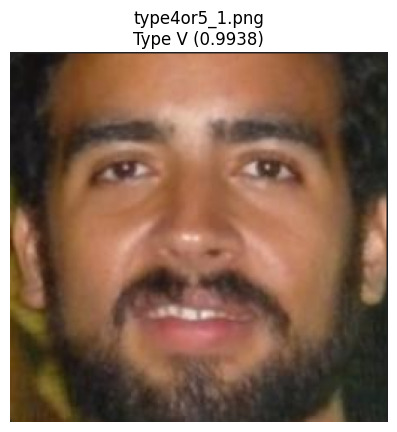

Image: as.jpg
Predicted: Type V (Confidence: 0.4525)



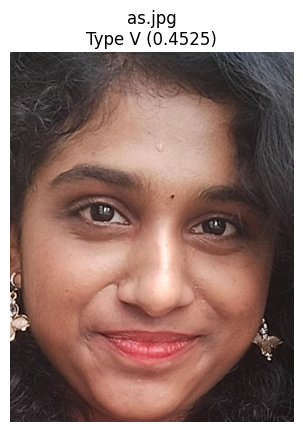

Image: hkn.jpg
Predicted: Type VI (Confidence: 0.8895)



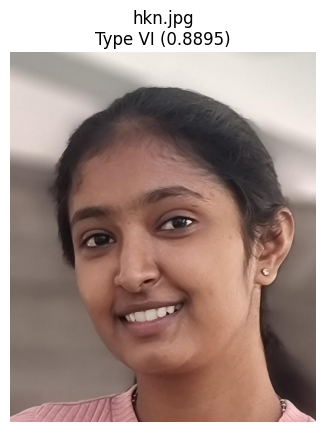

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

# Path to TFLite model and test images
tflite_model_path = '/content/drive/MyDrive/skin_type_classification/skin_type_model_compatible.tflite'
test_images_dir = '/content/drive/MyDrive/skin_type_classification/test_images'

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Class labels
class_labels = ['Type I/II', 'Type III', 'Type IV', 'Type V', 'Type VI']

# Preprocessing function
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)
    return img_array, Image.open(img_path)

# Inference loop over folder
image_files = list(Path(test_images_dir).glob("*.[jp][pn]g"))  # Handles .jpg, .png, .jpeg

for img_path in image_files:
    input_data, original_image = preprocess_image(str(img_path))

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Prediction
    predicted_class = np.argmax(output_data[0])
    confidence_score = output_data[0][predicted_class]
    predicted_label = class_labels[predicted_class]

    # Print result
    print(f"Image: {img_path.name}")
    print(f"Predicted: {predicted_label} (Confidence: {confidence_score:.4f})\n")

    # Display image and prediction
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"{img_path.name}\n{predicted_label} ({confidence_score:.4f})")
    plt.show()
